In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
        
def selectglaciersrgitable(glac_no=None,
                           rgi_regionsO1=None,
                           rgi_regionsO2=None,
                           rgi_glac_number=None,
#                            rgi_fp=input.rgi_fp,
                           rgi_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/RGI/rgi60/00_rgi60_attribs/',
                           rgi_cols_drop=['GLIMSId','BgnDate','EndDate','Status','Connect','Linkages','Name'],
                           rgi_O1Id_colname='glacno',
                           rgi_glacno_float_colname='RGIId_float',
                           indexname='GlacNo'):
    """
    Select all glaciers to be used in the model run according to the regions and glacier numbers defined by the RGI
    glacier inventory. This function returns the rgi table associated with all of these glaciers.

    glac_no : list of strings
        list of strings of RGI glacier numbers (e.g., ['1.00001', '13.00001'])
    rgi_regionsO1 : list of integers
        list of integers of RGI order 1 regions (e.g., [1, 13])
    rgi_regionsO2 : list of integers or 'all'
        list of integers of RGI order 2 regions or simply 'all' for all the order 2 regions
    rgi_glac_number : list of strings
        list of RGI glacier numbers without the region (e.g., ['00001', '00002'])

    Output: Pandas DataFrame of the glacier statistics for each glacier in the model run
    (rows = GlacNo, columns = glacier statistics)
    """
    if glac_no is not None:
        glac_no_byregion = {}
        rgi_regionsO1 = [int(i.split('.')[0]) for i in glac_no]
        rgi_regionsO1 = list(set(rgi_regionsO1))
        for region in rgi_regionsO1:
            glac_no_byregion[region] = []
        for i in glac_no:
            region = i.split('.')[0]
            glac_no_only = i.split('.')[1]
            glac_no_byregion[int(region)].append(glac_no_only)

        for region in rgi_regionsO1:
            glac_no_byregion[region] = sorted(glac_no_byregion[region])

    # Create an empty dataframe
    rgi_regionsO1 = sorted(rgi_regionsO1)
    glacier_table = pd.DataFrame()
    for region in rgi_regionsO1:

        if glac_no is not None:
            rgi_glac_number = glac_no_byregion[region]

#        if len(rgi_glac_number) < 50:

        for i in os.listdir(rgi_fp):
            if i.startswith(str(region).zfill(2)) and i.endswith('.csv'):
                rgi_fn = i
        try:
            csv_regionO1 = pd.read_csv(rgi_fp + rgi_fn)
        except:
            csv_regionO1 = pd.read_csv(rgi_fp + rgi_fn, encoding='latin1')
        
        # Populate glacer_table with the glaciers of interest
        if rgi_regionsO2 == 'all' and rgi_glac_number == 'all':
            print("All glaciers within region(s) %s are included in this model run." % (region))
            if glacier_table.empty:
                glacier_table = csv_regionO1
            else:
                glacier_table = pd.concat([glacier_table, csv_regionO1], axis=0)
        elif rgi_regionsO2 != 'all' and rgi_glac_number == 'all':
            print("All glaciers within subregion(s) %s in region %s are included in this model run." %
                  (rgi_regionsO2, region))
            for regionO2 in rgi_regionsO2:
                if glacier_table.empty:
                    glacier_table = csv_regionO1.loc[csv_regionO1['O2Region'] == regionO2]
                else:
                    glacier_table = (pd.concat([glacier_table, csv_regionO1.loc[csv_regionO1['O2Region'] ==
                                                                                regionO2]], axis=0))
        else:
            if len(rgi_glac_number) < 20:
                print("%s glaciers in region %s are included in this model run: %s" % (len(rgi_glac_number), region,
                                                                                       rgi_glac_number))
            else:
                print("%s glaciers in region %s are included in this model run: %s and more" %
                      (len(rgi_glac_number), region, rgi_glac_number[0:50]))
                
            rgiid_subset = ['RGI60-' + str(region).zfill(2) + '.' + x for x in rgi_glac_number] 
            rgiid_all = list(csv_regionO1.RGIId.values)
            rgi_idx = [rgiid_all.index(x) for x in rgiid_subset]
            if glacier_table.empty:
                glacier_table = csv_regionO1.loc[rgi_idx]
            else:
                glacier_table = (pd.concat([glacier_table, csv_regionO1.loc[rgi_idx]],
                                           axis=0))
                    
    glacier_table = glacier_table.copy()
    # reset the index so that it is in sequential order (0, 1, 2, etc.)
    glacier_table.reset_index(inplace=True)
    # change old index to 'O1Index' to be easier to recall what it is
    glacier_table.rename(columns={'index': 'O1Index'}, inplace=True)
    # Record the reference date
    glacier_table['RefDate'] = glacier_table['BgnDate']
    # if there is an end date, then roughly average the year
    enddate_idx = glacier_table.loc[(glacier_table['EndDate'] > 0), 'EndDate'].index.values
    glacier_table.loc[enddate_idx,'RefDate'] = (
            np.mean((glacier_table.loc[enddate_idx,['BgnDate', 'EndDate']].values / 10**4).astype(int),
                    axis=1).astype(int) * 10**4 + 9999)
    # drop columns of data that is not being used
    glacier_table.drop(rgi_cols_drop, axis=1, inplace=True)
    # add column with the O1 glacier numbers
    glacier_table[rgi_O1Id_colname] = (
            glacier_table['RGIId'].str.split('.').apply(pd.Series).loc[:,1].astype(int))
    glacier_table['rgino_str'] = [x.split('-')[1] for x in glacier_table.RGIId.values]
    glacier_table[rgi_glacno_float_colname] = (np.array([np.str.split(glacier_table['RGIId'][x],'-')[1]
                                                    for x in range(glacier_table.shape[0])]).astype(float))
    # set index name
    glacier_table.index.name = indexname

    print("This study is focusing on %s glaciers in region %s" % (glacier_table.shape[0], rgi_regionsO1))

    return glacier_table



class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.emvel = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()
        
        
#RGI uses 50 m bins
def hist_plot(gf, bin_width=50.0, dz_clim=(-2.0, 2.0), exportcsv=True):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.emvel is not None:
        emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(mz1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    if gf.debris_thick_ts is not None:
        debris_thick_ts_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.meltfactor_ts is not None:
        meltfactor_ts_med = np.ma.masked_all_like(z1_bin_areas)
        meltfactor_ts_mad = np.ma.masked_all_like(z1_bin_areas)

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        
        if gf.debris_thick_ts is not None:
            debris_thick_ts_bin_samp = gf.debris_thick_ts[(idx == bin_n+1)]
            if debris_thick_ts_bin_samp.size > min_bin_samp_count:
                debris_thick_ts_med[bin_n] = malib.fast_median(debris_thick_ts_bin_samp)
                debris_thick_ts_mad[bin_n] = malib.mad(debris_thick_ts_bin_samp)
        if gf.meltfactor_ts is not None:
            meltfactor_ts_bin_samp = gf.meltfactor_ts[(idx == bin_n+1)]
            if meltfactor_ts_bin_samp.size > min_bin_samp_count:
                meltfactor_ts_med[bin_n] = malib.fast_median(meltfactor_ts_bin_samp)
                meltfactor_ts_mad[bin_n] = malib.mad(meltfactor_ts_bin_samp)
                
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
        if gf.emvel is not None:
            emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
            if emvel_bin_samp.size > min_bin_samp_count:
                emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
                emvel_bin_std[bin_n] = emvel_bin_samp.std()
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, slope_bin_med, aspect_bin_med'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ', dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
        fmt += ', %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    
    if gf.debris_thick_ts is not None:
        outbins_header += ',debris_thick_ts_med_m,debris_thick_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_ts_med[debris_thick_ts_med == -(np.inf)] = 0.00
        debris_thick_ts_mad[debris_thick_ts_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_ts_med, debris_thick_ts_mad])
    if gf.meltfactor_ts is not None:
        outbins_header += ',meltfactor_ts_med_m,meltfactor_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        meltfactor_ts_med[meltfactor_ts_med == -(np.inf)] = 1
        meltfactor_ts_med[meltfactor_ts_med > 1] = 1
        meltfactor_ts_med[meltfactor_ts_med <= 0] = 1
        meltfactor_ts_mad[meltfactor_ts_mad == -(np.inf)] = 0
        meltfactor_ts_mad[meltfactor_ts_mad > 1] = 0
        meltfactor_ts_mad[meltfactor_ts_mad <= 0] = 0
        outbins.extend([meltfactor_ts_med, meltfactor_ts_mad])
    
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])
#         outbins_header += ', H_mean, H_std, emvel_mean, emvel_std'
#         fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    if gf.emvel is not None:
        outbins_header += ', emvel_mean, emvel_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([emvel_bin_mean, emvel_bin_std])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    if exportcsv:
        outbins_fn = os.path.join(outdir_csv, gf.feat_fn+'_emvel_stats_Farinotti-ITSLive' + str(int(bin_width))  + 'm.csv')
        np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)

#     #Create plots of elevation bins
#     #print("Generating aed plot")
#     #f,axa = plt.subplots(1,2, figsize=(6, 6))
#     nsubplots = 0
#     if gf.dhdt is not None:
#         nsubplots += 1
#     if gf.debris_thick is not None:
#         nsubplots += 1
#     if gf.vm is not None:
#         nsubplots += 1
#     if gf.H is not None:
#         nsubplots += 1
# #     print(nsubplots)
#     f,axa = plt.subplots(1,nsubplots, squeeze=False, figsize=(10, 7.5))
#     f.suptitle(gf.feat_fn)
#     fs = 9
#     nplot = -1
#     if gf.dhdt is not None:
#         nplot += 1
#         axa[0,nplot].plot(z1_bin_areas, z_bin_centers, label='%0.2f' % gf.t1_mean)
#         axa[0,nplot].axhline(gf.z1_ela, ls=':', c='C0')
#         if gf.z2 is not None:
#             axa[0,nplot].plot(z2_bin_areas, z_bin_centers, label='%0.2f' % gf.t2_mean)
#             axa[0,nplot].axhline(gf.z2_ela, ls=':', c='C1')
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         axa[0,nplot].set_ylabel('Elevation (m WGS84)', fontsize=fs)
#         axa[0,nplot].set_xlabel('Area $\mathregular{km^2}$', fontsize=fs)
#         axa[0,nplot].yaxis.set_ticks_position('both')
#         # pltlib.minorticks_on(axa[0])

#         nplot += 1
#         axa[0,nplot].axvline(0, lw=1.0, c='k')
#         """
#         #Plot flux divergence values for each bin
#         if gf.vm is not None and gf.H is not None:
#             divQ_bin_mean = np.gradient(H_bin_mean * vm_bin_med * v_col_f)
#             axa[1].plot(divQ_bin_mean, z_bin_centers, color='green')
#         """
#         axa[0,nplot].plot(mb_bin_med, z_bin_centers, color='k')
#         axa[0,nplot].axvline(gf.mb_mean, lw=0.5, ls=':', c='k', label='%0.2f m w.e./yr' % gf.mb_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, mb_bin_med-mb_bin_mad, mb_bin_med+mb_bin_mad, color='k', alpha=0.1)
#         axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med<0), color='r', alpha=0.2)
#         axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med>0), color='b', alpha=0.2)
#         #axa[nplot].set_xlabel('dh/dt (m/yr)')
#         axa[0,nplot].set_xlabel('Mass balance (m w.e./yr)', fontsize=fs)
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         axa[0,nplot].yaxis.set_ticks_position('both')
#         # pltlib.minorticks_on(axa[1])
#         #Hide y-axis labels
#         axa[0,nplot].axes.yaxis.set_ticklabels([])
#         axa[0,nplot].set_xlim(*dz_clim)

#     if gf.debris_thick is not None:
#         nplot += 1
#         axa[0,nplot].errorbar(debris_thick_med*100., z_bin_centers, xerr=debris_thick_mad*100, color='k', fmt='o', ms=3, label='Debris Thickness', alpha=0.6)
#     if gf.debris_class is not None:
#         axa[0,nplot].plot(perc_debris, z_bin_centers, color='sienna', label='Debris Coverage')
#         axa[0,nplot].plot(perc_pond, z_bin_centers, color='turquoise', label='Pond Coverage')
#     if gf.debris_thick is not None or gf.debris_class is not None:
#         axa[0,nplot].set_xlim(0, 100)
#         axa[0,nplot].yaxis.set_ticks_position('both')
#         # pltlib.minorticks_on(axa[2])
#         axa[0,nplot].axes.yaxis.set_ticklabels([])
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         axa[0,nplot].set_xlabel('Debris thickness (cm), coverage (%)', fontsize=fs)

#     if gf.H is not None:
#         nplot += 1
#         axa[0,nplot].plot(H_bin_mean, z_bin_centers, color='b', label='H (%0.2f m)' % gf.H_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, H_bin_mean-H_bin_std, H_bin_mean+H_bin_std, color='b', alpha=0.1)
#         axa[0,nplot].set_xlabel('Ice Thickness (m)', fontsize=fs)
#         axa[0,nplot].legend(prop={'size':8}, loc='lower right')
#         # pltlib.minorticks_on(axa[3])
#         #axa[nplot].set_xlim(0, 400)
#         axa[0,nplot].yaxis.tick_left()
#         axa[0,nplot].yaxis.set_ticks_position('both')
#         axa[0,nplot].yaxis.set_label_position("right")
    
#     if gf.vm is not None:
#         nplot += 1
# #         ax4 = axa[0,nplot].twinx()
#         axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        
#         nplot += 1
# #         axa[0,nplot].set_xlabel('divQ (??)', fontsize=fs)
# #         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
# #         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
# #         #ax4.set_xlim(0, 50)
# #         axa[0,nplot].xaxis.tick_bottom()
# #         axa[0,nplot].xaxis.set_label_position("bottom")
# #         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
# #         gf.divQ
    
# #     if gf.vm is not None:
# #         nplot += 1
# # #         ax4 = axa[0,nplot].twinx()
# #         axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
# #         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
# #         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
# #         #ax4.set_xlim(0, 50)
# #         axa[0,nplot].xaxis.tick_bottom()
# #         axa[0,nplot].xaxis.set_label_position("bottom")
# #         axa[0,nplot].legend(prop={'size':8}, loc='upper right')

#     plt.tight_layout()
#     #Make room for suptitle
#     plt.subplots_adjust(top=0.95, wspace=0.1)
#     #print("Saving aed plot")
#     fig_fn = os.path.join(outdir_fig, gf.feat_fn+'_mb_aed.png')
#     #plt.savefig(fig_fn, bbox_inches='tight', dpi=300)
#     plt.savefig(fig_fn, dpi=300)
#     plt.close(f)
    
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    return outbins_df, z_bin_edges
#     return z_bin_edges

In [2]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

import globaldebris_input as input

verbose=True
extra_layers=True
min_glac_area_writeout=0
min_valid_area_perc = 0
buff_dist = 1000
bin_width = 5
#Surface to column average velocity scaling
v_col_f = 0.8

#INPUT
glac_shp_fn_dict = {'13':input.main_directory + '/../../../HiMAT/RGI/rgi60/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp',
                    '14':input.main_directory + '/../../../HiMAT/RGI/rgi60/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp',
                    '15':input.main_directory + '/../../../HiMAT/RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'}
glac_shp_proj_fp = input.output_fp + 'glac_shp_proj/'
if os.path.exists(glac_shp_proj_fp) == False:
    os.makedirs(glac_shp_proj_fp)

#DEM
z1_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/' + 
          'surface_DEMs_RGI60-XXXX/')
z1_fn_sample = 'surface_DEM_RGI60-XXXX.tif'
# Ice thickness
huss_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/' + 
                   'composite_thickness_RGI60-all_regions/RGI60-XXXX/')
huss_fn_sample = 'RGI60-XXXX_thickness.tif'
#Surface velocity
v_dir = input.main_directory + '/../../../Satellite_Images/ITS_Live'
vx_fn = os.path.join(v_dir, 'HMA_G0120_0000_vx.tif')
vy_fn = os.path.join(v_dir, 'HMA_G0120_0000_vy.tif')

# topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
# #Output directory
# outdir = topdir + 'Shean_2019_0213/mb_combined_20190213_nmad_bins/'
# outdir_fig = outdir + '/figures/'
outdir_csv = input.output_fp + 'csv/'
outdir_fig = input.output_fp + 'figures/'

if os.path.exists(glac_shp_proj_fp) == False:
    os.makedirs(glac_shp_proj_fp)
if os.path.exists(outdir_csv) == False:
    os.makedirs(outdir_csv)
if os.path.exists(outdir_fig) == False:
    os.makedirs(outdir_fig)

In [3]:
rgiid_list = []
rgiid_fn_list = []
for i in os.listdir(input.mb_binned_fp):
    if i.endswith('mb_bins.csv'):
        rgiid_list.append(i[0:8])
        rgiid_fn_list.append(i)
        
rgiid_list = sorted(rgiid_list)
rgiid_fn_list = sorted(rgiid_fn_list)

print(len(rgiid_list))

main_glac_rgi = selectglaciersrgitable(rgiid_list)
main_glac_rgi['bin_fn'] = rgiid_fn_list

8053
4182 glaciers in region 13 are included in this model run: ['00062', '00093', '00130', '00135', '00137', '00140', '00147', '00175', '00181', '00183', '00203', '00210', '00277', '00358', '00382', '00386', '00391', '00394', '00400', '00401', '00403', '00439', '00440', '00441', '00465', '00561', '00585', '00594', '00604', '00606', '00611', '00628', '00643', '00693', '00713', '00750', '00751', '00757', '00761', '00763', '00777', '00788', '00809', '00830', '00834', '00838', '00880', '00884', '00885', '00891'] and more
2468 glaciers in region 14 are included in this model run: ['00005', '00018', '00032', '00036', '00043', '00057', '00063', '00072', '00088', '00101', '00104', '00111', '00131', '00142', '00145', '00146', '00159', '00163', '00164', '00187', '00213', '00219', '00222', '00225', '00235', '00243', '00251', '00271', '00287', '00309', '00323', '00326', '00336', '00346', '00347', '00352', '00353', '00363', '00366', '00367', '00370', '00372', '00380', '00398', '00403', '00432', '0

0 6940 RGI60-15.03473
Shp init crs: {'init': 'epsg:4326'}


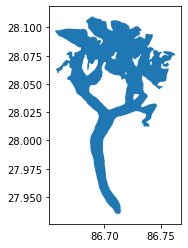

In [4]:
# for nglac, glac_idx in enumerate(main_glac_rgi.index.values):
for nglac, glac_idx in enumerate([main_glac_rgi.index.values[6940]]):
    glac_str = main_glac_rgi.loc[glac_idx,'rgino_str']
    rgiid = main_glac_rgi.loc[glac_idx,'RGIId']
    
    print(nglac, glac_idx, rgiid)
    
    region = glac_str.split('.')[0]
    
    # Shape layer processing
    glac_shp_init = gpd.read_file(glac_shp_fn_dict[region])
    if verbose:
        print('Shp init crs:', glac_shp_init.crs)

    glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
    glac_shp_single = glac_shp_single.reset_index()
    
    # Plot glacier
    ax = glac_shp_single.plot()

In [5]:
# Project shapefile
huss_dir = huss_dir_sample.replace('XXXX',str(region.zfill(2)))
huss_fn = huss_fn_sample.replace('XXXX',glac_str)

proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
ds = gdal.Open(proj_fn)
prj = ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)
aea_srs = srs

# If projected shapefile already exists, then skip projection
glac_shp_proj_fn = glac_shp_proj_fp + glac_str + '_crs' + str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'

if os.path.exists(glac_shp_proj_fn) == False:
    glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
    glac_shp_proj.to_file(glac_shp_proj_fn)

glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
glac_shp_lyr = glac_shp_ds.GetLayer()
#This should be contained in features
glac_shp_srs = glac_shp_lyr.GetSpatialRef()
feat_count = glac_shp_lyr.GetFeatureCount()
print("Input glacier polygon count: %i" % feat_count)

Input glacier polygon count: 1


In [6]:
# Load DEM
z1_dir = z1_dir_sample.replace('XXXX',str(region.zfill(2)))
z1_fn = z1_fn_sample.replace('XXXX',glac_str)

z1_ds = gdal.Open(z1_dir + z1_fn)
z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

# glac_shp_lyr = None
# glac_shp_ds = None

In [7]:
glacfeat_list = []
glacname_fieldname = "Name"
#RGIId (String) = RGI50-01.00004
glacnum_fieldname = "RGIId"
glacnum_fmt = '%08.5f'

for n, feat in enumerate(glac_shp_lyr):
    gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
    print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
    #NOTE: Input must be in projected coordinate system, ideally equal area
    #Should check this and reproject
    gf.geom_attributes(srs=aea_srs)
    glacfeat_list.append(gf)
    
print(gf.feat_fn)

1 of 1: 15.03473
15.03473


In [8]:
out_csv_fn = os.path.join(outdir_csv, gf.feat_fn+'_emergence.csv')
if verbose:
    print('output_fn:', out_csv_fn)
    
# if not os.path.exists(out_csv_fn):
for batman in [0]:
    print('\n\nREPLACE AGAIN SO DONT PROCESS GLACIERS ALREADY PROCESSED\n\n')
    
    fn_dict = OrderedDict()
    #We at least want to warp the two input DEMs
    fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        print(gf.glacnum)
        
        # Ice thickness data
        ice_thick_fn = os.path.join(huss_dir, huss_fn)
        if os.path.exists(ice_thick_fn):
            fn_dict['ice_thick'] = ice_thick_fn
        
        print(fn_dict['ice_thick'])

        if os.path.exists(vx_fn):
            fn_dict['vx'] = vx_fn
            fn_dict['vy'] = vy_fn
            
#         if os.path.exists(ts_fullfn):
#             fn_dict['ts'] = ts_fullfn
            
#         if os.path.exists(debris_fullfn):
#             fn_dict['debris_thick_ts'] = debris_fullfn

    #Expand extent to include buffered region around glacier polygon
    warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
    if verbose:
        print("Expanding extent")
        print(gf.glac_geom_extent)
        print(warp_extent)
        print(aea_srs)

    #Warp everything to common res/extent/proj
    ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
            extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
            r='cubic')

    ds_dict = dict(zip(fn_dict.keys(), ds_list))
    
    print(ds_list)
    print(fn_dict.keys())
    
    #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
    glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
    glac_shp_lyr = glac_shp_ds.GetLayer()
    #Spatial filter
#     glac_shp_lyr.SetSpatialFilter(geom)

    #Get global glacier mask
    #Want this to be True over ALL glacier surfaces, not just the current polygon
    glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
    
    #geom srs is not preserved when loaded from disk, attempt to reassign
#     gf.geom_srs_update()
    #Create buffer around glacier polygon
    glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
    #This is False over glacier polygon surface, True elsewhere - can be applied directly
    glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])
    
    # ds masks
    ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
    dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
    dems_mask = dem1.mask
    if verbose:
        print('list of datasets:', len(ds_list_masked), fn_dict.values())
    
    #Combine to identify ~1 km buffer around glacier polygon over static rock
    static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
    static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

    if 'z1' in ds_dict:
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
        gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
        #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
        print('\n\n# z1 pixels:', gf.z1.count(), '\n')
        if gf.z1.count() == 0:
            if verbose:
                print("No z1 pixels")
#             return None
    else:
        print("Unable to load z1 ds")
#         return None

output_fn: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../output/csv/15.03473_emergence.csv


REPLACE AGAIN SO DONT PROCESS GLACIERS ALREADY PROCESSED


15.03473
/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/composite_thickness_RGI60-all_regions/RGI60-15/RGI60-15.03473_thickness.tif
Expanding extent
[466274.413315571, 3090038.90589917, 476685.521575542, 3109419.82835597]
[465274.413315571, 3089038.90589917, 477685.521575542, 3110419.82835597]
PROJCS["WGS 84 / UTM zone 45N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
  

In [9]:
print('\n\nHACK TO BYPASS VALID AREA\n\n')
gf.valid_area_perc = 100

if gf.valid_area_perc < (100. * min_valid_area_perc):
    if verbose:
        print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
#     return None

else:
    #Filter dz - throw out abs differences >150 m

    #Compute dz, volume change, mass balance and stats
    gf.z1_stats = malib.get_stats(gf.z1)
    z1_elev_med = gf.z1_stats[5]
    z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))
    
    #Caluclate stats for aspect and slope using z2
    #Requires GDAL 2.1+
    gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
    gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
    z1_aspect_med = gf.z1_aspect_stats[5]
    gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
    gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
    z1_slope_med = gf.z1_slope_stats[5]

    #Can estimate ELA values computed from hypsometry and typical AAR
    #For now, assume ELA is mean
    gf.z1_ela = None
    gf.z1_ela = gf.z1_stats[3]
    #Note: in theory, the ELA should get higher with mass loss
    #In practice, using mean and same polygon, ELA gets lower as glacier surface thins


    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        if 'ice_thick' in ds_dict:
            #Load ice thickness
            gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
            gf.H_mean = gf.H.mean()
            print('mean ice thickness [m]:', gf.H_mean)

        if 'vx' in ds_dict and 'vy' in ds_dict:
            #Load surface velocity maps
            gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
            gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
            gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
            gf.vm_mean = gf.vm.mean()
            
            print('mean velocity [m/s]:', gf.vm_mean)

            if gf.H is not None:
                #Compute flux
                gf.Q = gf.H * v_col_f * np.array([gf.vx, gf.vy])
                #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                #Want x-derivative of x component
                gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

#                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
#                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                #Should smooth divQ, better handling of data gaps
                
        if 'ts' in ds_dict:
            #Load surface temperature maps
            gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
        else:
            gf.ts = None
            
        if 'debris_thick_ts' in ds_dict:
            # Load debris thickness map
            gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask)
            gf.meltfactor_ts = None
        else:
            gf.debris_thick_ts = None
            gf.meltfactor_ts = None

    if verbose:
        print('Area [km2]:', gf.glac_area / 1e6)
        print('-------------------------------')



HACK TO BYPASS VALID AREA


mean ice thickness [m]: 113.6750727250379
mean velocity [m/s]: 13.25236868521326
Area [km2]: 61.00664962245946
-------------------------------


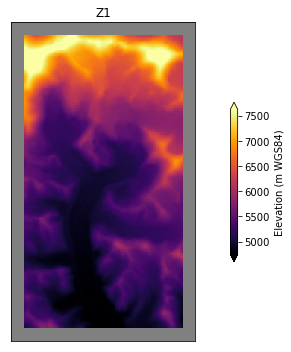

In [10]:
titles = ['Z1']
z1_full2plot = gf.z1
z1_full2plot.mask = dems_mask
clim = malib.calcperc(z1_full2plot, (2,98))
plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=outdir_fig + glac_str + '_dem.png')

(428, 248)


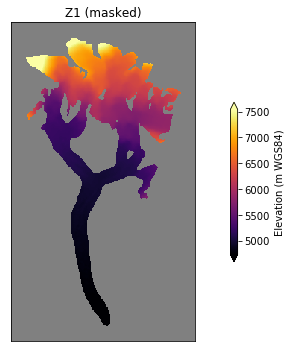

In [11]:
#Now apply glacier mask AND mask NaN values
glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# nan_mask = np.ma.masked_invalid(gf.dz)
# glac_geom_mask = np.ma.mask_or(glac_geom_mask, nan_mask.mask)
gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Z1 (masked)']
clim = malib.calcperc(gf.z1, (2,98))
plot_array(gf.z1, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=outdir_fig + glac_str + '_dem.png')

print(gf.z1.shape)

(428, 248)


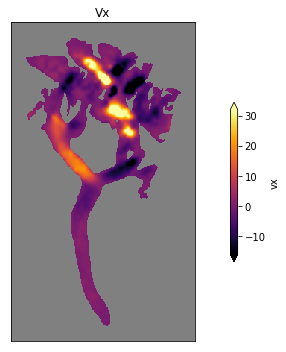

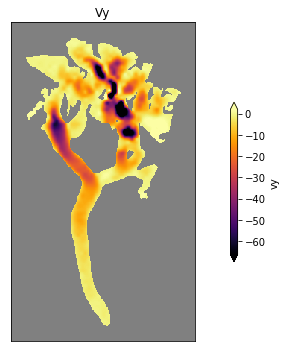

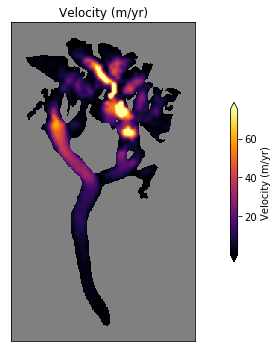

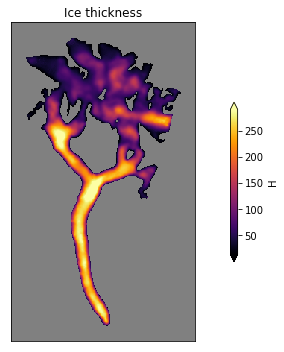

In [12]:
titles = ['Vx']
var_full2plot = gf.vx
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'vx', fn=outdir_fig + gf.feat_fn +'_vx.png')

titles = ['Vy']
var_full2plot = gf.vy
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'vy', fn=outdir_fig + gf.feat_fn +'_vy.png')

gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

titles = ['Velocity (m/yr)']
var_full2plot = gf.vtot
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=outdir_fig + glac_str +'_velocity.png')

print(var_full2plot.shape)

titles = ['Ice thickness']
var_full2plot = gf.H
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'H', fn=outdir_fig + gf.feat_fn +'_ice_thickness.png')

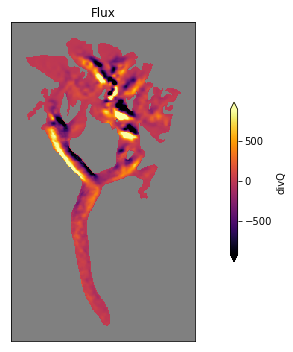

In [13]:
titles = ['Flux']
divQ_full2plot = gf.divQ
divQ_full2plot.mask = glac_geom_mask
clim = malib.calcperc(divQ_full2plot, (2,98))
plot_array(divQ_full2plot, clim, titles, 'inferno', 'divQ', fn=outdir_fig + glac_str +'_divQ.png')

In [20]:
def emergence_pixels(gf, vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
#     print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres) + 1
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of ice cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
          
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            
    ############
    glac_mask = np.zeros(gf.vx.shape) + 1
    glac_mask[gf.z1.mask] = 0
    offglac_row, offglac_col = np.where((glac_mask == 0) & (volume_final > 0))

    def nearest_nonzero_idx(a,x,y):
        r,c = np.nonzero(a)
        min_idx = ((r - x)**2 + (c - y)**2).argmin()
        return r[min_idx], c[min_idx]

    for nidx in range(0,len(offglac_row)):
        nrow = offglac_row[nidx]
        ncol = offglac_col[nidx]
        ridx, cidx = nearest_nonzero_idx(glac_mask, nrow, ncol)
        
        # Add off-glacier volume back onto nearest pixel on glacier
        volume_final[ridx,cidx] += volume_final[nrow,ncol]
        volume_final[nrow,ncol] = 0
        
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    print('Mass is conserved?', np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() < 0.01)
    print(np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum())
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity

vx = np.ma.filled(gf.vx,0)
vy = np.ma.filled(gf.vy,0)
H = np.ma.filled(gf.H,0)
vx[gf.z1 > gf.z1.max()] = 0
vy[gf.z1 > gf.z1.max()] = 0
H[gf.z1 > gf.z1.max()] = 0
vmax = gf.vm.max()

# Emergence computation
emvel = emergence_pixels(vx, vy, H,
                         gf.res[0], gf.res[1], positive_is_east=False, 
                         positive_is_north=False, constant_icethickness=False, max_velocity=vmax, vel_min=0)
gf.emvel = np.ma.masked_array(emvel, mask=gf.z1.mask)

# previous with masked array
# gf.emvel = emergence_pixels(gf.vx, gf.vy, gf.H, gf.res[0], gf.res[1], positive_is_east=False, 
#                             positive_is_north=False, constant_icethickness=False, max_velocity=600, vel_min=0)

Mass is conserved? True
4.1601098804169687e-08


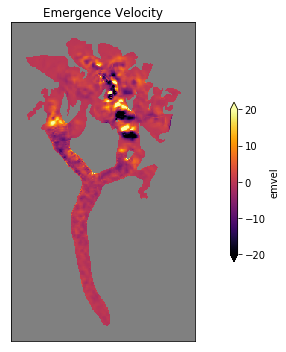

In [21]:
titles = ['Emergence Velocity']
# gf.emvel[300:315,85:90] = 1000
# gf.emvel[210:220,95:105] = 1000
var_full2plot = gf.emvel
clim = (-20,20)
# clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'emvel', fn= outdir_fig + glac_str +'_emergence_velocity.png')

In [22]:
# SAMPLE TEST CALC
xres, yres = 50,50
vel_depth_avg_factor = 0.8

print('ADD GLACIER MASK TO FUNCTION')
glac_mask = np.zeros(gf.vx.shape) + 1
glac_mask[gf.z1.mask] = 0


glac_mask = glac_mask[220:225,93:96]
vel_y_raw = gf.vy[220:225,93:96].copy()
vel_y = -1*vel_y_raw * vel_depth_avg_factor
vel_y[vel_y.shape[0]-1,:] = 0
vel_y[:,:] = 0

vel_x = gf.vx[220:225,93:96].copy()
vel_x[:,0] = 0
print(vel_x[:,1])

icethickness = gf.H[220:225,93:96].copy()
icethickness[:,:] = 1
icethickness[:,0] = 0
volume_initial = icethickness * (xres * yres)

vel_total = (vel_y**2 + vel_x**2)**0.5

pix_maxres = xres
if yres > pix_maxres:
    pix_maxres = yres
    
print('velocity:', vel_y[:,0])
         
# Compute displacement in units of pixels
vel_x_pix = vel_x / xres
vel_y_pix = vel_y / yres

print('displacement_x:', vel_x_pix[:,0])
print('displacement_y:', vel_y_pix[:,0])
# Compute the displacement and fraction of pixels moved for all columns (x-axis)
# col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
#    int() automatically rounds towards zero
col_x1 = vel_x_pix.astype(int)
# col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
#    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
# rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
#    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
#    then when you take the remainder using "% 1", you obtain the desired fraction
rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
# rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
rem_x1 = 1 - rem_x2
# Repeat the displacement and fraction computations for all rows (y-axis)
row_y1 = vel_y_pix.astype(int)
row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
rem_y1 = 1 - rem_y2

print('row_x1:', col_x1[:,1])
print('rem_x1:', rem_x1[:,1])
print('row_x2:', col_x2[:,1])
print('rem_x2:', rem_x2[:,1])

# print('row_y1:', row_y1[:,0])
# print('rem_y1:', rem_y1[:,0])
# print('row_y2:', row_y2[:,0])
# print('rem_y2:', rem_y2[:,0])

# Compute the mass flux for each pixel
volume_final = np.zeros(volume_initial.shape)
for r in range(vel_x.shape[0]):
    for c in range(vel_x.shape[1]):
        volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
            )
        volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
            )
        volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
            )
        volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
            )
   
    
# Final ice thickness
icethickness_final = volume_final / (xres * yres)
# Emergence velocity
emergence_velocity = icethickness_final - icethickness

print(volume_final[:,0:2], '\n', volume_initial[:,0:2])
print(emergence_velocity[:,0:2])



ADD GLACIER MASK TO FUNCTION
[-0.5034812688827515 -0.6103498339653015 -0.7336636781692505
 -0.9010363817214966 -1.103981614112854]
velocity: [0.0 0.0 0.0 0.0 0.0]
displacement_x: [0.0 0.0 0.0 0.0 0.0]
displacement_y: [0.0 0.0 0.0 0.0 0.0]
row_x1: [0 0 0 0 0]
rem_x1: [0.9899304  0.987793   0.9853267  0.98197925 0.97792035]
row_x2: [-1 -1 -1 -1 -1]
rem_x2: [0.01006963 0.012207   0.01467327 0.01802073 0.02207963]
[[  25.17406273 2514.31342316]
 [  30.51749229 2513.70071793]
 [  36.68318558 2513.05070496]
 [  45.05181503 2512.9706459 ]
 [  55.19907761 2512.99755859]] 
 [[0.0 2500.0]
 [0.0 2500.0]
 [0.0 2500.0]
 [0.0 2500.0]
 [0.0 2500.0]]
[[0.010069625091552735 0.00572536926269529]
 [0.01220699691772461 0.0054802871704100475]
 [0.014673274230957031 0.005220281982421859]
 [0.018020726013183594 0.005188258361816356]
 [0.02207963104248047 0.0051990234374998945]]


In [23]:

    
print(volume_final[:,0:2], '\n', volume_initial[:,0:2])
print(emergence_velocity[:,0:2])

[[  25.17406273 2514.31342316]
 [  30.51749229 2513.70071793]
 [  36.68318558 2513.05070496]
 [  45.05181503 2512.9706459 ]
 [  55.19907761 2512.99755859]] 
 [[0.0 2500.0]
 [0.0 2500.0]
 [0.0 2500.0]
 [0.0 2500.0]
 [0.0 2500.0]]
[[0.010069625091552735 0.00572536926269529]
 [0.01220699691772461 0.0054802871704100475]
 [0.014673274230957031 0.005220281982421859]
 [0.018020726013183594 0.005188258361816356]
 [0.02207963104248047 0.0051990234374998945]]


In [24]:
#Do AED for all
#Compute mb using scaled AED vs. polygon
#Check for valid pixel count vs. feature area, fill if appropriate
if gf.glac_area_km2 > min_glac_area_writeout:
    outbins_df, z_bin_edges = hist_plot(gf, bin_width=bin_width)
    
    if verbose:
        print(outbins_df.loc[0:5,:])

   bin_center_elev_m   z1_bin_count_valid   z1_bin_area_valid_km2  \
0             4702.5                 14.0                  0.0350   
1             4707.5                 71.0                  0.1775   
2             4712.5                 67.0                  0.1675   
3             4717.5                 65.0                  0.1625   
4             4722.5                 74.0                  0.1850   
5             4727.5                103.0                  0.2575   

    z1_bin_area_perc   z2_bin_count_valid   z2_bin_area_valid_km2  \
0           0.057371                 14.0                  0.0350   
1           0.290952                 71.0                  0.1775   
2           0.274560                 67.0                  0.1675   
3           0.266364                 65.0                  0.1625   
4           0.303246                 74.0                  0.1850   
5           0.422085                103.0                  0.2575   

    z2_bin_area_perc   slope_bin

   bin_center_elev_m   z1_bin_count_valid   z1_bin_area_valid_km2  \
0             4702.5                 14.0                  0.0350   
1             4707.5                 71.0                  0.1775   
2             4712.5                 67.0                  0.1675   
3             4717.5                 65.0                  0.1625   
4             4722.5                 74.0                  0.1850   
5             4727.5                103.0                  0.2575   

    z1_bin_area_perc   z2_bin_count_valid   z2_bin_area_valid_km2  \
0           0.057371                 14.0                  0.0350   
1           0.290952                 71.0                  0.1775   
2           0.274560                 67.0                  0.1675   
3           0.266364                 65.0                  0.1625   
4           0.303246                 74.0                  0.1850   
5           0.422085                103.0                  0.2575   

    z2_bin_area_perc   slope_bin